In [1]:
import sys
sys.path.append('../')

from utils.dataset import  CustomDataset
import os
import warnings
warnings.filterwarnings("ignore")
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
import threading
import random
# import rasterio
import os
import numpy as np
import sys
from sklearn.utils import shuffle as shuffle_lists
import numpy as np
from sklearn.model_selection import train_test_split
import joblib

import torch

#default
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

#trasnform
from torchvision import transforms
from utils.transform import *

#dataset
from utils.dataset import CustomDataset
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from torchsummary import summary
from torchsampler import ImbalancedDatasetSampler

#metric
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import torchmetrics.functional as tf

#numeric
import numpy as np
import pandas as pd 

#visualization
import matplotlib.pyplot as plt

#system 
from tqdm import tqdm
import os 
import wandb
import datetime


In [2]:
now = datetime.datetime.now()
formatted_now = now.strftime("%Y%m%d%H%M")
checkpoint_datetime = formatted_now
print(f"#"*30, "SAVE TIME", "#"*30)
print(f"#"*30, checkpoint_datetime, "#"*30)

############################## SAVE TIME ##############################
############################## 202403220813 ##############################


In [3]:
from torch.utils.data import Dataset
from torchvision import transforms
import torch 
import os 
from PIL import Image
import numpy as np
import pandas as pd 
import rasterio

class CustomDataset(Dataset):
    def __init__(self, csv_path, transform = None, MAX_PIXEL_VALUE = 65535, band = None): #transform 가지고올거있으면 가지고 오기
        self.MAX_PIXEL_VALUE = MAX_PIXEL_VALUE 
        self.band = band
        self.transform = transform
        self.image_paths, self.mask_paths = self.csv_load(csv_path = csv_path, type = csv_path.split('/')[-1].split('_')[0])
    
    def csv_load(self, csv_path, type):
        self.type = type 
        df = pd.read_csv(csv_path)
        # os.pathconf('../')
        image_paths = f'../../dataset/{type}_img/' + df[f'{type}_img']
        mask_paths = f'../../dataset/{type}_mask/' + df[f'{type}_mask']
        
        return  image_paths, mask_paths
        
    def get_img_arr(self, path):
        # img = rasterio.open(path).read().transpose((1, 2, 0))
        img = rasterio.open(path).read(self.band).transpose((1, 2, 0))
        img = np.float32(img)/self.MAX_PIXEL_VALUE

        return img
    
    def get_mask_arr(self, path):
        img = rasterio.open(path).read().transpose((1, 2, 0))
        seg = np.float32(img)
        return seg
    
    def __len__(self):
        return len(self.image_paths) 
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        images = self.get_img_arr(path = image_path)
        masks = self.get_mask_arr(path = mask_path)
        
        # # transform 
        if self.transform:
            images = self.transform(images)
        
        return images, masks

In [4]:
train_csv = '../../dataset/train_meta.csv'

train_transform = transforms.Compose([
    transforms.ToTensor(),
    RandomColorJitterTransform(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
    # ColorJitterTransform(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.1),  # Color space transformation
    RandomDropout(p=0.2),  # Random dropout
    
])
tr_batch = 2
vl_batch = 2

dataset = CustomDataset(
    csv_path= train_csv,
    transform= train_transform, #None으로 세팅
    MAX_PIXEL_VALUE= 65535,
    band = (7,6,2) #기존 세팅 
)

# 훈련 및 검증 세트 분할
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size 
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = tr_batch,
    # sampler= ImbalancedDatasetSampler(train_dataset),
    shuffle = True
)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = vl_batch, shuffle= False)



torch.Size([2, 3, 256, 256]) torch.Size([2, 256, 256, 1])


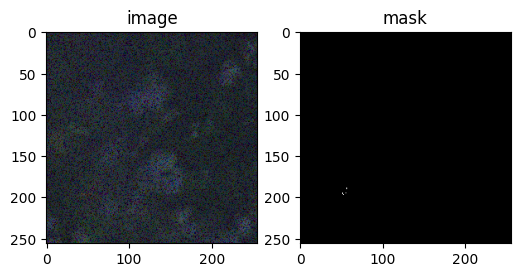

In [5]:
for images, masks in train_loader:
    print(images.shape, masks.shape)
    idx = 0
    plt.figure(figsize=(6,4))
    plt.subplot(121)
    plt.imshow(images[idx].permute(1,2,0))
    plt.title('image')
    plt.subplot(122)
    plt.imshow(masks[idx], cmap= 'gray')
    plt.title('mask')
    plt.show()
    break

# for images, masks in valid_loader:
#     print(images.shape)
#     idx = 0
#     plt.figure(figsize=(6,4))
#     plt.subplot(121)
#     plt.imshow(images[idx])
#     plt.title('image')
#     plt.subplot(122) 
#     plt.imshow(masks[idx], cmap= 'gray')
#     plt.title('mask')
#     plt.show()
#     break

In [6]:
#model
sys.path.append('../')
from network.models import get_pretrained_model

# if torch.cuda.is_available():
#     device = 'cuda'
#     torch.cuda.manual_seed_all(42)
device = 'cuda'
# # random seed 고정
# random.seed(42)
# if torch.cuda.is_available():
#     device = torch.device('cuda')
#     torch.cuda.manual_seed_all(42)
# else:
#     device = torch.device('cuda')
#     torch.manual_seed_all(42)

# # model & cost func & optimizer 정의
############################ V1~2 #############################
model = get_pretrained_model('unet').get()
############################ V3~4 #############################
# model = AttU_Net(img_ch= 3, output_ch= 1)
# model = get_pretrained_model('attunet').get()
# model = get_pretrained_model('r2attunet').get()
############################ V5 #############################
# model = get_pretrained_model('unet++').get()
############################ V6 #############################
# model = get_pretrained_model('manet').get()

model.to(device)

lr = 0.0001
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda= lambda epoch: 0.95**epoch)

loss = nn.BCEWithLogitsLoss()

print(f'device : {device}')
# summary(model, input_size=(3, 224, 224))



Using cache found in /home/oj/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [ ]:
metrics = {
    'tr_bce' : [],
    'vl_bce' : [],
    'tr_iou' : [],
    'vl_iou' : [],
}
epoch, epochs = 0, 200
early_stopping_epochs, early_stopping_cnt= 10, 0
SAVE_DIR = '../../satellite_model'
best_loss = float('inf')


In [ ]:
def checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds):
    # loss plot
    plt.figure(figsize=(10, 7))
    plt.subplot(121)
    plt.plot(metrics['tr_bce'], label='Train Loss')
    plt.plot(metrics['vl_bce'], label='Valid Loss')
    plt.title("BCE | DOWN GOOD")
    plt.legend()
    plt.subplot(122)
    plt.plot(metrics['tr_iou'], label='Train IoU')
    plt.plot(metrics['vl_iou'], label='Valid IoU')
    plt.title("mIOU | UP GOOD")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}_loss.png'))
    plt.close()
    
    # mask plot
    plt.figure(figsize=(10, 7))
    plt.subplot(131)
    plt.imshow(images[0].cpu().permute(1,2,0))
    plt.title('image')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(masks[0].cpu().permute(1,2,0))
    plt.title('mask')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(preds[0].cpu().permute(1,2,0))
    plt.title('pred')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}_mask.png'))
    plt.close()
    
    torch.save({
        "model" : f"{epoch}",
        "epoch" : epoch,
        "epochs" : epochs,
        "model_state_dict" : model.state_dict(),
        "optimizer_state_dict" : optimizer.state_dict(),
        "learning_rate" : lr,
        "loss" : loss,
        "metric" : metrics,
        "description" : f"segmentation model training status : {epoch}/{epochs}"
    },
    os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}.pt'))
    print(f"#"*30, f"SAVE PATH : {SAVE_DIR}", "#"*30)
    
def calculate_iou(preds, masks, threshold=0.5):
    # 예측 마스크를 이진 형태로 변환
    preds = (preds > threshold).float()
    
    intersection = torch.sum(preds * masks)
    union = torch.sum((preds + masks) > 0)
    
    iou = (intersection + 1e-7) / (union + 1e-7)  # 0으로 나누는 경우를 방지하기 위해 작은 값(1e-7)을 추가
    
    return iou

In [ ]:
for epoch in tqdm(range(epoch, epochs), desc="Training Progress"):
    train_losses, valid_losses = 0., 0.
    train_ious, valid_ious = 0., 0.
    
    model.train()
    for _, (images, masks) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images, masks = images.to(device), masks.to(device)
        images = images
        masks = masks.permute(0,3,1,2)
        
        preds = model(images) 

        train_loss = loss(preds, masks).to(device)
        train_iou = calculate_iou(preds, masks).cpu().detach().numpy()
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_losses += train_loss.item()
        train_ious += train_iou
        break 
    scheduler.step()
    
    metrics['tr_bce'].append(train_losses / len(train_loader))
    metrics['tr_iou'].append(train_ious / len(train_loader))
    print(f"Epoch : {epoch}/{epochs} | Train Loss : {train_losses / len(train_loader)}")
    print(f"Epoch : {epoch}/{epochs} | Train IOU : {train_ious / len(train_loader)}")
    
    with torch.no_grad():
        model.eval()
        for _, (images, masks) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            images, masks = images.to(device), masks.to(device)
            images = images
            masks = masks.permute(0,3,1,2)

            preds = model(images)
            valid_loss = loss(preds, masks).to(device)
            valid_iou = calculate_iou(preds, masks).cpu().detach().numpy()
        
            valid_losses += valid_loss.item()
            valid_ious += valid_iou
            break
            

    metrics['vl_bce'].append(valid_losses / len(valid_loader))
    metrics['vl_iou'].append(valid_ious / len(valid_loader))
    print(f"Epoch : {epoch}/{epochs} | Valid Loss : {valid_losses / len(valid_loader)}")
    print(f"Epoch : {epoch}/{epochs} | Valid IOU : {valid_ious / len(valid_loader)}")

    # Early Stopping
    if valid_losses < best_loss:
        best_loss = valid_losses
        early_stopping_cnt = 0
        # checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds)

    else:
        early_stopping_cnt += 1
        if early_stopping_cnt >= early_stopping_epochs:
            print(f"Early Stops!!! : {epoch}/{epochs}")
            # checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds)
    
    # Validation 성능이 이전보다 우수한 경우 모델 저장
    try:        
        if valid_losses > np.array(metrics['vl_bce'])[:-1].max() and epoch%10 == 0:
            pass
            # checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds)
    except Exception as e:
        print(e)
        pass

  0%|          | 0/13430 [00:00<?, ?it/s] [00:00<?, ?it/s]


Epoch : 0/200 | Train Loss : 5.5117595577453025e-05
Epoch : 0/200 | Train IOU : 7.426707057929705e-16


Training Progress:   0%|          | 1/200 [00:00<00:24,  8.13it/s]

Epoch : 0/200 | Valid Loss : 0.00020641990187907942
Epoch : 0/200 | Valid IOU : 9.606332670631863e-13
zero-size array to reduction operation maximum which has no identity


  0%|          | 0/13430 [00:00<?, ?it/s]


Epoch : 1/200 | Train Loss : 5.359478788595988e-05
Epoch : 1/200 | Train IOU : 1.3272756818081123e-15


  0%|          | 0/3358 [00:00<?, ?it/s]


Epoch : 1/200 | Valid Loss : 0.00020642018587976925
Epoch : 1/200 | Valid IOU : 9.606332670631863e-13


  0%|          | 0/13430 [00:00<?, ?it/s]


Epoch : 2/200 | Train Loss : 5.4041778340059166e-05
Epoch : 2/200 | Train IOU : 1.1009930815556945e-15


Training Progress:   2%|▏         | 3/200 [00:00<00:18, 10.62it/s]

Epoch : 2/200 | Valid Loss : 0.00020642071838106266
Epoch : 2/200 | Valid IOU : 9.606332670631863e-13


  0%|          | 0/13430 [00:00<?, ?it/s]


Epoch : 3/200 | Train Loss : 5.2098711302097573e-05
Epoch : 3/200 | Train IOU : 8.568488413707942e-08


  0%|          | 0/3358 [00:00<?, ?it/s]


Epoch : 3/200 | Valid Loss : 0.0002064210556318818
Epoch : 3/200 | Valid IOU : 9.606332670631863e-13


  0%|          | 0/13430 [00:00<?, ?it/s]


Epoch : 4/200 | Train Loss : 5.246333816738512e-05
Epoch : 4/200 | Train IOU : 3.1272644149944636e-15


Training Progress:   2%|▎         | 5/200 [00:00<00:17, 10.93it/s]

Epoch : 4/200 | Valid Loss : 0.0002064345101645619
Epoch : 4/200 | Valid IOU : 7.444907637898519e-13


  0%|          | 0/13430 [00:00<?, ?it/s]


Epoch : 5/200 | Train Loss : 5.221760104329215e-05
Epoch : 5/200 | Train IOU : 5.124581366519723e-15


  0%|          | 0/3358 [00:00<?, ?it/s]


Epoch : 5/200 | Valid Loss : 0.00020643809567327085
Epoch : 5/200 | Valid IOU : 6.925495846179441e-13


  0%|          | 0/13430 [00:00<?, ?it/s]


Epoch : 6/200 | Train Loss : 5.230129608358808e-05
Epoch : 6/200 | Train IOU : 3.824353549982871e-15


Training Progress:   4%|▎         | 7/200 [00:00<00:17, 10.96it/s]

Epoch : 6/200 | Valid Loss : 0.00020642501389149615
Epoch : 6/200 | Valid IOU : 8.758714751426381e-13


  0%|          | 0/13430 [00:00<?, ?it/s]


Epoch : 7/200 | Train Loss : 5.287287932940588e-05
Epoch : 7/200 | Train IOU : 2.082801747733983e-15


  0%|          | 0/3358 [00:00<?, ?it/s]


Epoch : 7/200 | Valid Loss : 0.00020644531994081807
Epoch : 7/200 | Valid IOU : 6.204089588041993e-13


  0%|          | 0/13430 [00:00<?, ?it/s]


Epoch : 8/200 | Train Loss : 5.2555909550908956e-05
Epoch : 8/200 | Train IOU : 2.8715837414554923e-15


Training Progress:   4%|▍         | 9/200 [00:00<00:17, 11.08it/s]

Epoch : 8/200 | Valid Loss : 0.00020647192725544531
Epoch : 8/200 | Valid IOU : 4.581481775916158e-13


  0%|          | 0/13430 [00:00<?, ?it/s]


Epoch : 9/200 | Train Loss : 5.2153957662348063e-05
Epoch : 9/200 | Train IOU : 5.217951081557005e-15


  0%|          | 0/3358 [00:00<?, ?it/s]


Epoch : 9/200 | Valid Loss : 0.0002064806780267003
Epoch : 9/200 | Valid IOU : 4.315888524071062e-13


  0%|          | 0/13430 [00:00<?, ?it/s]


Epoch : 10/200 | Train Loss : 5.221705958635525e-05
Epoch : 10/200 | Train IOU : 5.527852399223391e-08


Training Progress:   6%|▌         | 11/200 [00:01<00:17, 10.85it/s]

Epoch : 10/200 | Valid Loss : 0.00020643694192046846
Epoch : 10/200 | Valid IOU : 8.048548922827708e-13
Early Stops!!! : 10/200


  0%|          | 0/13430 [00:00<?, ?it/s]


Epoch : 11/200 | Train Loss : 5.2116597133701806e-05
Epoch : 11/200 | Train IOU : 7.16652217423952e-15


  0%|          | 0/3358 [00:00<?, ?it/s]


Epoch : 11/200 | Valid Loss : 0.00020651482910965084
Epoch : 11/200 | Valid IOU : 3.202111000417393e-13
Early Stops!!! : 11/200


  0%|          | 0/13430 [00:00<?, ?it/s]


Epoch : 12/200 | Train Loss : 5.257890815621246e-05
Epoch : 12/200 | Train IOU : 2.760851549858728e-15


Training Progress:   6%|▋         | 13/200 [00:01<00:17, 10.64it/s]

Epoch : 12/200 | Valid Loss : 0.00020644617194288752
Epoch : 12/200 | Valid IOU : 9.606332670631863e-13
Early Stops!!! : 12/200


  0%|          | 0/13430 [00:00<?, ?it/s]


Epoch : 13/200 | Train Loss : 5.20124243695791e-05
Epoch : 13/200 | Train IOU : 7.285730614826647e-15


  0%|          | 0/3358 [00:00<?, ?it/s]


Epoch : 13/200 | Valid Loss : 0.00020658831428814104
Epoch : 13/200 | Valid IOU : 2.157944262035531e-13
Early Stops!!! : 13/200


  0%|          | 0/13430 [00:00<?, ?it/s]


Epoch : 14/200 | Train Loss : 5.185536191433291e-05
Epoch : 14/200 | Train IOU : 1.3178791739850992e-07


Training Progress:   8%|▊         | 15/200 [00:01<00:17, 10.54it/s]

Epoch : 14/200 | Valid Loss : 0.00020651564561163406
Epoch : 14/200 | Valid IOU : 3.4627479230897205e-13
Early Stops!!! : 14/200


  0%|          | 0/13430 [00:00<?, ?it/s]


Epoch : 15/200 | Train Loss : 5.185317389572723e-05
Epoch : 15/200 | Train IOU : 1.4628715629434944e-14


  0%|          | 0/3358 [00:00<?, ?it/s]


Epoch : 15/200 | Valid Loss : 0.00020657972326727406
Epoch : 15/200 | Valid IOU : 2.308498505186375e-13
Early Stops!!! : 15/200


  0%|          | 0/13430 [00:00<?, ?it/s]


Epoch : 16/200 | Train Loss : 5.176729527499724e-05
Epoch : 16/200 | Train IOU : 2.425412605098669e-14


Training Progress:   8%|▊         | 17/200 [00:01<00:16, 10.99it/s]

Epoch : 16/200 | Valid Loss : 0.00020659981631607864
Epoch : 16/200 | Valid IOU : 2.1896786878565952e-13
Early Stops!!! : 16/200


  0%|          | 0/13430 [00:00<?, ?it/s]


Epoch : 17/200 | Train Loss : 5.188645574466026e-05
Epoch : 17/200 | Train IOU : 1.2087689581797057e-14


  0%|          | 0/3358 [00:00<?, ?it/s]


Epoch : 17/200 | Valid Loss : 0.00020661218809612882
Epoch : 17/200 | Valid IOU : 2.0680299177840506e-13
Early Stops!!! : 17/200


  0%|          | 0/13430 [00:00<?, ?it/s]


Epoch : 18/200 | Train Loss : 5.1782260789679484e-05
Epoch : 18/200 | Train IOU : 2.0683378481432506e-14


Training Progress:  10%|▉         | 19/200 [00:01<00:16, 11.26it/s]

Epoch : 18/200 | Valid Loss : 0.00020662203937005683
Epoch : 18/200 | Valid IOU : 1.9853087144602823e-13
Early Stops!!! : 18/200


  0%|          | 0/13430 [00:00<?, ?it/s]


Epoch : 19/200 | Train Loss : 5.178281999930285e-05
Epoch : 19/200 | Train IOU : 2.6592916666616582e-14


  0%|          | 0/3358 [00:00<?, ?it/s]


Epoch : 19/200 | Valid Loss : 0.0002066142648511731
Epoch : 19/200 | Valid IOU : 2.1736956751800194e-13
Early Stops!!! : 19/200


  0%|          | 0/13430 [00:00<?, ?it/s]


Epoch : 20/200 | Train Loss : 5.175994566280453e-05
Epoch : 20/200 | Train IOU : 2.897282604117787e-14


Training Progress:  10%|█         | 21/200 [00:01<00:15, 11.60it/s]

Epoch : 20/200 | Valid Loss : 0.0002066195011138916
Epoch : 20/200 | Valid IOU : 2.2560326976953856e-13
Early Stops!!! : 20/200


  0%|          | 0/13430 [00:00<?, ?it/s]


Epoch : 21/200 | Train Loss : 5.1832904765966304e-05
Epoch : 21/200 | Train IOU : 1.2599012178536743e-14


  0%|          | 0/3358 [00:00<?, ?it/s]


Epoch : 21/200 | Valid Loss : 0.00020655863621605515
Epoch : 21/200 | Valid IOU : 3.4229461962226866e-13
Early Stops!!! : 21/200


  0%|          | 0/13430 [00:00<?, ?it/s]


Epoch : 22/200 | Train Loss : 5.166981083549676e-05
Epoch : 22/200 | Train IOU : 8.366310870695935e-14


Training Progress:  12%|█▏        | 23/200 [00:02<00:15, 11.39it/s]

Epoch : 22/200 | Valid Loss : 0.00020649352905791456
Epoch : 22/200 | Valid IOU : 9.606332670631863e-13
Early Stops!!! : 22/200


  0%|          | 0/13430 [00:00<?, ?it/s]


Epoch : 23/200 | Train Loss : 5.1827956204616745e-05
Epoch : 23/200 | Train IOU : 1.4346852902349173e-14


  0%|          | 0/3358 [00:00<?, ?it/s]


Epoch : 23/200 | Valid Loss : 0.00020649786006843426
Epoch : 23/200 | Valid IOU : 9.606332670631863e-13
Early Stops!!! : 23/200


Training Progress:  12%|█▏        | 24/200 [00:02<00:16, 10.93it/s]


KeyboardInterrupt: 